<div class="alert alert-success">
    <center> <h1> <font size="8"> Dirichlet Example </font> </h1> </center>
</div>

<br/>
<br/>

The Dirichlet distribution is commonly used for modelling non-negative compositional data, i.e., data that consist of sub-sets that are fractions of some total. Compositional data are typically represented as proportions or percentages summing to 100\%, so that the Dirichlet extends the univariate beta-distribution to the multivariate case. Compositional data analysis (CoDa) is a branch of statistics that deals with multivariate observations carrying relative information and finds widespread use in ecology, economics or political science. As a result of the unit-sum constraint, models that use distributions designed for unconstrained data typically suffer from the problem of spurious correlation when applied to compositional data. 

In this example, we model and predict all parameters of a Dirichlet distribution with $Y_{D}=3$ target variables using the famous Arctic-Lake dataset. The density of the Dirichlet distribution with parameters $\mathbf{\alpha}_{\mathbf{x}} = (\alpha_{\mathbf{x},1}, \ldots, \alpha_{\mathbf{x},D}) \in \mathbb{R}^{D}_{+}$ with $\sum^{D}_{d=1}y_{d}=1$ for all $y_{d}\in \left[0,1\right]$ is given by

$$
f\big(\mathbf{y}|\mathbf{\theta}_{\mathbf{x}}\big) = \frac{1}{\mathrm{B}(\mathbf{\alpha}_{\mathbf{x}})} \prod_{d=1}^{D}y^{\alpha_{\mathbf{x},d-1}}_{d}
$$

To ensure positivity, we use $\exp(\alpha_{\mathbf{x},d})$ for all $d=1,\ldots, D$. The estimated parameters have the interpretation of providing the probability of an event falling into category $d$, i.e., $\mathbb{E}(y_{d}) = \frac{\alpha_{d}}{\alpha_{0}}$, with $\alpha_{0} = \sum^{D}_{d=1}\alpha_{d}$. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br/>
<br/>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.DIRICHLET import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_example_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy distribution and initialize model

In [2]:
distribution = DIRICHLET(D=3)     # Dirichlet distribution, where D specifies the number of target variables
pyblss = PyBoostLSS(distribution) # Initializes model with specified distribution

# Data

In [3]:
data_df = load_example_data("arcticlake.csv")

# Create 80%, 10%, 10% split for train, validation and test 
train, validate, test = np.split(data_df.sample(frac=1,random_state=123), [int(0.8*len(data_df)), int(0.9*len(data_df))])

# Train
x_train = train["depth"].values.reshape(-1,1)
y_train = train.drop(columns="depth").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate["depth"].values.reshape(-1,1)
y_eval = validate.drop(columns="depth").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test["depth"].values.reshape(-1,1)
y_test = test.drop(columns="depth").values

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [1.0, 1.0],                      # increased to max due to small size of dataset
           "subsample": [1.0, 1.0],                      # increased to max due to small size of dataset
           "min_gain_to_split": [0, 500]  
          }  

opt_param = pyblss.hyper_opt(params=hp_dict,
                             dtrain=dtrain,
                             eval_sets=eval_sets,
                             use_hess=True, 
                             sketch_method="proj",
                             hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                             ntrees=500,                 # Number of boosting iterations.
                             es=20,                      # Early stopping rounds
                             n_trials=10,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-08 11:33:16,505] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

[11:33:25] Stdout logging level is INFO.
[11:33:25] GDBT train starts. Max iter 500, early stopping rounds 20
[11:33:31] Iter 0; Sample 0, NLL-score = -5.127476677854759; 
[11:33:35] Early stopping at iter 190, best iter 170, best_score -10.250120833771959
[I 2022-12-08 11:33:36,535] Trial 0 finished with value: -10.2501292414331 and parameters: {'lr': 0.2261559634886368, 'max_depth': 1, 'sketch_outputs': 7, 'lambda_l2': 30.88877600549751, 'colsample': 1.0, 'subsample': 1.0, 'min_gain_to_split': 71.47732298654863}. Best is trial 0 with value: -10.2501292414331.
[11:33:36] Stdout logging level is INFO.
[11:33:36] GDBT train starts. Max iter 500, early stopping rounds 20
[11:33:36] Iter 0; Sample 0, NLL-score = -4.7779778049753485; 
[11:33:38] Early stopping at iter 62, best iter 42, best_score -9.890179422452471
[I 2022-12-08 11:33:38,303] Trial 1 finished with value: -9.890167654880095 and parameters: {'lr': 0.5377869141302691, 'max_depth': 2, 'sketch_outputs': 10, 'lambda_l2': 22.0473

# Model Training

In [5]:
opt_params = opt_param.copy()

pyboostlss_model = pyblss.train(dtrain=dtrain,
                                lr=opt_params["lr"], 
                                lambda_l2=opt_params["lambda_l2"],
                                max_depth=opt_params["max_depth"],
                                sketch_outputs=opt_params["sketch_outputs"],
                                colsample=opt_params["colsample"],
                                subsample=opt_params["subsample"],
                                min_gain_to_split=opt_params["min_gain_to_split"],
                                ntrees=opt_params["opt_rounds"],
                                use_hess=True,
                                verbose=100,                                
                                sketch_method="proj",
                                seed=123)

[11:34:09] Stdout logging level is INFO.
[11:34:09] GDBT train starts. Max iter 39, early stopping rounds 100
[11:34:09] Iter 0; 
[11:34:09] Iter 38; 


# Predict

In [6]:
# Predicts transformed parameters of the specified distribution. 
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_train,          # Here we use the train dataset to later infer the partial dependence of the parameters on x
                                    pred_type="parameters")
predt_params.head()

,alpha_1,alpha_2,alpha_3
0,8.925608,5.909983,1.225174
1,8.925608,5.909983,1.225174
2,1.241373,10.116554,4.594018
3,1.782198,11.356755,9.836135
4,8.925608,5.909983,1.225174


Please note that the predicted parameters are not yet on the response-scale. Yet we can transform them easily as described above: the estimated parameters have the interpretation of providing the probability of an event falling into category $d$, i.e., $\mathbb{E}(y_{d}) = \frac{\alpha_{d}}{\alpha_{0}}$, with $\alpha_{0} = \sum^{D}_{d=1}\alpha_{d}$.

In [10]:
# Transform to response scale
predt_params_transf = predt_params / predt_params.sum(axis=1)
predt_params_transf = predt_params.div(predt_params.sum(axis=1), axis=0)
predt_params_transf.columns = data_df.iloc[:,:3].columns

predt_params_transf.head()

,sand,silt,clay
0,0.555740,0.367976,0.076284
1,0.555740,0.367976,0.076284
2,0.077820,0.634189,0.287991
3,0.077571,0.494307,0.428122
4,0.555740,0.367976,0.076284


In [8]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
n_samples = 10000
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,         
                                     pred_type="samples",   
                                     n_samples=n_samples)

predt_samples.shape # Output-shape is (n_samples, n_obs, n_target)

(10000, 4, 3)

# Partial Dependence Plot

Since there is only one covariate in the dataset, we can infer the effect of depth (in meters) on the sediment composition using a scatter-smooth estimate. The figure shows that with increasing depth, the relative frequency of sand decreases while the proportion of silt and clay increases.

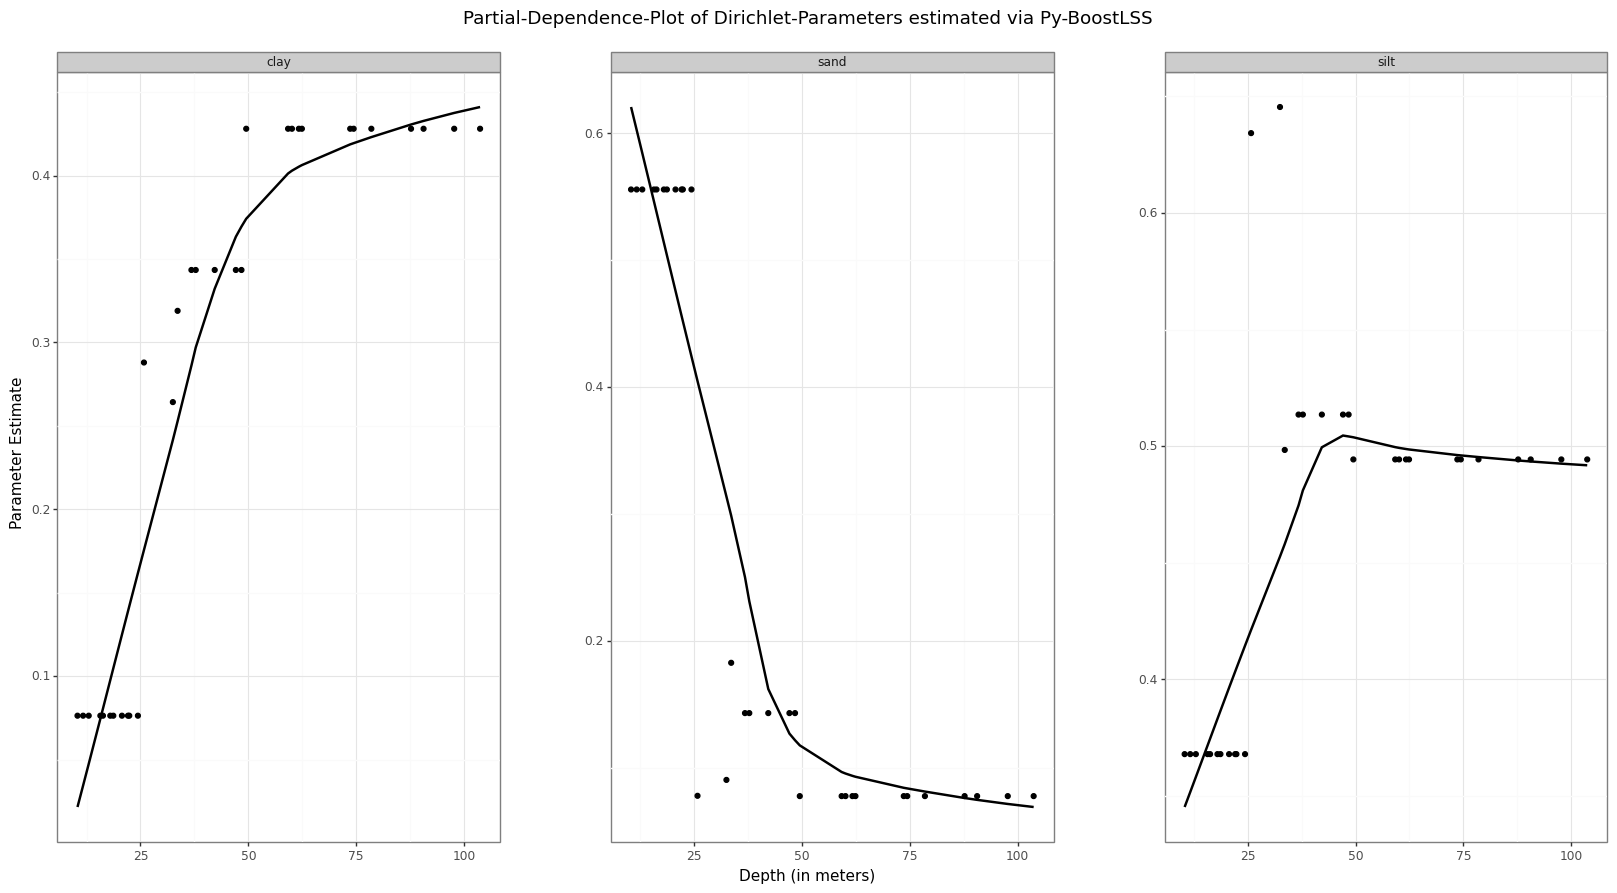

In [9]:
plot_df = predt_params_transf
plot_df["depth"] = x_train

plot_df = pd.melt(plot_df,
                  id_vars="depth")

param_plot = (ggplot(plot_df,
                     aes(x="depth",
                         y="value")) + 
              geom_point() + 
              geom_smooth(span=0.7, se=False) + 
              facet_wrap("variable",
                         scales="free") + 
              theme_bw() + 
              theme(subplots_adjust={"wspace": 0.25}) + 
              labs(title = "Partial-Dependence-Plot of Dirichlet-Parameters estimated via Py-BoostLSS\n",
                   y="Parameter Estimate",
                   x="Depth (in meters)") 
             )

print(param_plot)